<a href="https://colab.research.google.com/github/bala1802/ERA_Session18/blob/main/UNET/S18_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/MyDrive/Session-18

/content/drive/MyDrive/Session-18


In [2]:
# cd ERA_Session18

In [3]:
# !git pull

# !git clone https://github.com/bala1802/ERA_Session18.git

In [4]:
cd /content/drive/MyDrive/Session-18/ERA_Session18/UNET

/content/drive/MyDrive/Session-18/ERA_Session18/UNET


In [5]:
!pip install torchinfo --quiet
!pip install matplotlib --quiet
!pip install imageio --quiet

In [6]:
from torchinfo import summary
import torch

from contracting_block import ContractingBlock
from expanding_block import ExpandingBlock
from unet import Unet
from oxford_dataset import OxfordDataset

import data_loader
import loss
import train
import transform
import config
import predictions
import download

Hello world


#### UNET Model Summary

In [7]:
unet_model = Unet(in_channels=3, out_channels=3,StrConv=True,ConvTr=False)
summary(model= unet_model, input_size=(32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                              [32, 3, 128, 128]    [32, 3, 128, 128]    --                   True
├─ContractingBlock (contract1)           [32, 3, 128, 128]    [32, 32, 64, 64]     --                   True
│    └─Conv2d (conv1)                    [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
│    └─BatchNorm2d (bn1)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu1)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (conv2)                    [32, 32, 128, 128]   [32, 32, 128, 128]   9,248                True
│    └─BatchNorm2d (bn2)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu2)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (str

#### Load Data

In [8]:
# petTrainData = download.download_data(path="/content/drive/MyDrive/Session-18/data/train", split="trainval")
# petTestData = download.download_data(path="/content/drive/MyDrive/Session-18/data/test", split="test")

import torchvision

pets_path_train = "/content/drive/MyDrive/Session-18/data/train"
pets_path_test = "/content/drive/MyDrive/Session-18/data/test"

pets_train_data = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_data = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

100%|██████████| 791918971/791918971 [00:26<00:00, 29500792.37it/s]


Extracting /content/drive/MyDrive/Session-18/data/train/oxford-iiit-pet/images.tar.gz to /content/drive/MyDrive/Session-18/data/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 15117422.35it/s]


Extracting /content/drive/MyDrive/Session-18/data/train/oxford-iiit-pet/annotations.tar.gz to /content/drive/MyDrive/Session-18/data/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:34<00:00, 22921302.15it/s]


Extracting /content/drive/MyDrive/Session-18/data/test/oxford-iiit-pet/images.tar.gz to /content/drive/MyDrive/Session-18/data/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 13900935.44it/s]


Extracting /content/drive/MyDrive/Session-18/data/test/oxford-iiit-pet/annotations.tar.gz to /content/drive/MyDrive/Session-18/data/test/oxford-iiit-pet


In [9]:
# pets_path_train = "/content/drive/MyDrive/Session-18/data/train"
# pets_path_test = "/content/drive/MyDrive/Session-18/data/test"

petdata_train = transform.manual_transform(path=pets_path_train, split="trainval")
petdata_test = transform.manual_transform(path=pets_path_test, split="test")

In [10]:
train_dataloader = data_loader.get_data_loader(petdata_train)
test_dataloader = data_loader.get_data_loader(petdata_test)

# Training

#### Model Configuration: MP + Tr + BCE

In [11]:
unet_1 = Unet(in_channels=3, out_channels=3, StrConv=False, ConvTr=True).to(config.device)
optimizer = torch.optim.Adam(params = unet_1.parameters(),lr=0.001)

print(summary(model= unet_1, input_size = (32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                              [32, 3, 128, 128]    [32, 3, 128, 128]    --                   True
├─ContractingBlock (contract1)           [32, 3, 128, 128]    [32, 32, 64, 64]     4,128                True
│    └─Conv2d (conv1)                    [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
│    └─BatchNorm2d (bn1)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu1)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (conv2)                    [32, 32, 128, 128]   [32, 32, 128, 128]   9,248                True
│    └─BatchNorm2d (bn2)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu2)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─MaxPool2d (

In [12]:
train_losses,test_losses = train.train_unet(my_unet=unet_1,
                                            loss_fn=loss.cross_entropy_loss(),
                                            device=config.device,
                                            train_dataloader=train_dataloader,
                                            test_dataloader=test_dataloader,
                                            optimizer=optimizer)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6109 | test_loss: 0.5297 
Epoch: 2 | train_loss: 0.4626 | test_loss: 0.5322 
Epoch: 3 | train_loss: 0.4094 | test_loss: 0.3898 
Epoch: 4 | train_loss: 0.3582 | test_loss: 0.3567 
Epoch: 5 | train_loss: 0.3409 | test_loss: 0.3449 
Epoch: 6 | train_loss: 0.3263 | test_loss: 0.3303 
Epoch: 7 | train_loss: 0.3028 | test_loss: 0.3516 
Epoch: 8 | train_loss: 0.2889 | test_loss: 0.3253 
Epoch: 9 | train_loss: 0.2707 | test_loss: 0.3267 
Epoch: 10 | train_loss: 0.2682 | test_loss: 0.3207 
Epoch: 11 | train_loss: 0.2534 | test_loss: 0.3279 
Epoch: 12 | train_loss: 0.2379 | test_loss: 0.3436 
Epoch: 13 | train_loss: 0.2311 | test_loss: 0.3281 
Epoch: 14 | train_loss: 0.2253 | test_loss: 0.2987 
Epoch: 15 | train_loss: 0.2215 | test_loss: 0.2973 
Epoch: 16 | train_loss: 0.2068 | test_loss: 0.2952 
Epoch: 17 | train_loss: 0.1951 | test_loss: 0.2849 
Epoch: 18 | train_loss: 0.2051 | test_loss: 0.2923 
Epoch: 19 | train_loss: 0.1849 | test_loss: 0.2888 
Epoch: 20 | train_los

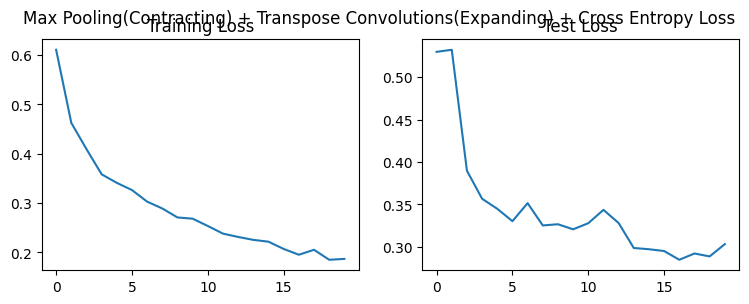

In [13]:
loss.plot_losses(train_losses=train_losses,
                 test_losses=test_losses,
                 title="Max Pooling(Contracting) + Transpose Convolutions(Expanding) + Cross Entropy Loss")

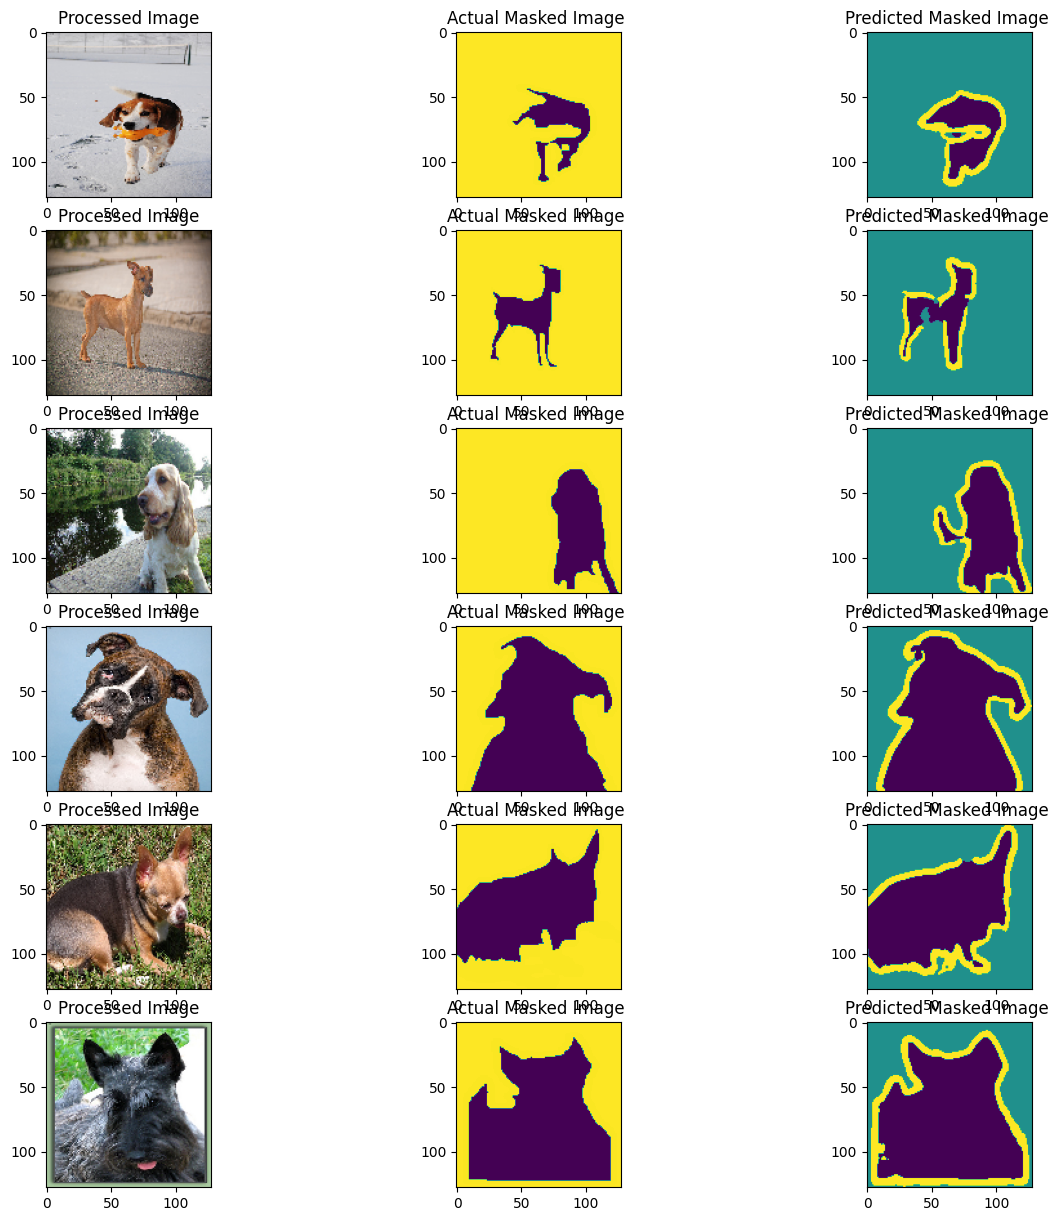

In [14]:
predictions.VisualizeResults(unet_model = unet_1, test_dataloader=test_dataloader)

#### Model Configuration: MP + Tr + Dice Loss

In [15]:
unet_2 = Unet(in_channels=3, out_channels=3,StrConv=False,ConvTr=True).to(config.device)
optimizer = torch.optim.Adam(params = unet_2.parameters(),lr=0.001)
print(summary(model= unet_2, input_size=(32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                              [32, 3, 128, 128]    [32, 3, 128, 128]    --                   True
├─ContractingBlock (contract1)           [32, 3, 128, 128]    [32, 32, 64, 64]     4,128                True
│    └─Conv2d (conv1)                    [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
│    └─BatchNorm2d (bn1)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu1)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (conv2)                    [32, 32, 128, 128]   [32, 32, 128, 128]   9,248                True
│    └─BatchNorm2d (bn2)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu2)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─MaxPool2d (

In [17]:
train_losses,test_losses = train.train_unet(my_unet=unet_2,
                                            loss_fn=loss.dice_loss_fn,
                                            device=config.device,
                                            train_dataloader=train_dataloader,
                                            test_dataloader=test_dataloader,
                                            optimizer=optimizer)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3795 | test_loss: 0.2882 
Epoch: 2 | train_loss: 0.2740 | test_loss: 0.2554 
Epoch: 3 | train_loss: 0.2498 | test_loss: 0.2249 
Epoch: 4 | train_loss: 0.2324 | test_loss: 0.2196 
Epoch: 5 | train_loss: 0.2252 | test_loss: 0.2464 
Epoch: 6 | train_loss: 0.2168 | test_loss: 0.2176 
Epoch: 7 | train_loss: 0.2097 | test_loss: 0.2073 
Epoch: 8 | train_loss: 0.2063 | test_loss: 0.2293 
Epoch: 9 | train_loss: 0.1976 | test_loss: 0.2023 
Epoch: 10 | train_loss: 0.1953 | test_loss: 0.1997 
Epoch: 11 | train_loss: 0.1911 | test_loss: 0.1942 
Epoch: 12 | train_loss: 0.1854 | test_loss: 0.1973 
Epoch: 13 | train_loss: 0.1804 | test_loss: 0.1960 
Epoch: 14 | train_loss: 0.1785 | test_loss: 0.2094 
Epoch: 15 | train_loss: 0.1754 | test_loss: 0.1772 
Epoch: 16 | train_loss: 0.1697 | test_loss: 0.1869 
Epoch: 17 | train_loss: 0.1675 | test_loss: 0.1812 
Epoch: 18 | train_loss: 0.1646 | test_loss: 0.1853 
Epoch: 19 | train_loss: 0.1620 | test_loss: 0.1707 
Epoch: 20 | train_los

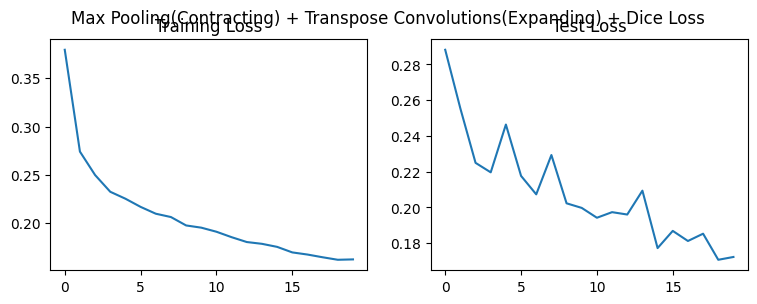

In [18]:
loss.plot_losses(train_losses=train_losses,
                 test_losses=test_losses,
                 title="Max Pooling(Contracting) + Transpose Convolutions(Expanding) + Dice Loss")

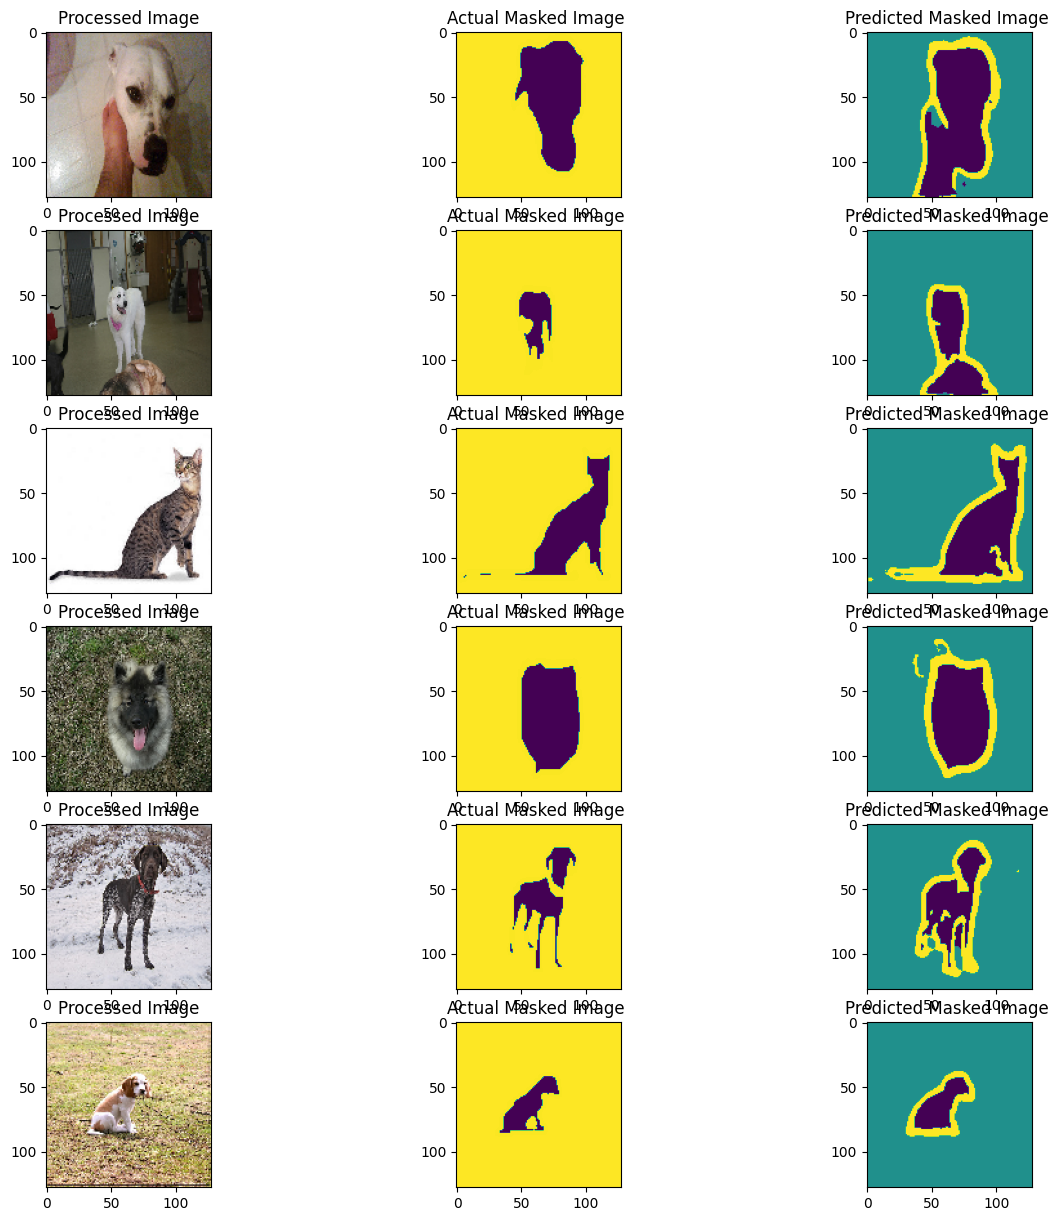

In [19]:
predictions.VisualizeResults(unet_model = unet_2, test_dataloader=test_dataloader)

#### Model Configuration: StrConv + Tr + BCE

In [20]:
unet_3 = Unet(in_channels=3, out_channels=3,StrConv=True,ConvTr=True).to(config.device)
optimizer = torch.optim.Adam(params = unet_3.parameters(),lr=0.001)
print(summary(model= unet_3, input_size=(32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                              [32, 3, 128, 128]    [32, 3, 128, 128]    --                   True
├─ContractingBlock (contract1)           [32, 3, 128, 128]    [32, 32, 64, 64]     --                   True
│    └─Conv2d (conv1)                    [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
│    └─BatchNorm2d (bn1)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu1)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (conv2)                    [32, 32, 128, 128]   [32, 32, 128, 128]   9,248                True
│    └─BatchNorm2d (bn2)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu2)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (str

In [21]:
train_losses,test_losses = train.train_unet(my_unet=unet_3,
                                            loss_fn=loss.cross_entropy_loss(),
                                            device=config.device,
                                            train_dataloader=train_dataloader,
                                            test_dataloader=test_dataloader,
                                            optimizer=optimizer)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6556 | test_loss: 0.7542 
Epoch: 2 | train_loss: 0.5260 | test_loss: 0.5059 
Epoch: 3 | train_loss: 0.4566 | test_loss: 0.5219 
Epoch: 4 | train_loss: 0.4099 | test_loss: 0.3800 
Epoch: 5 | train_loss: 0.3892 | test_loss: 0.3706 
Epoch: 6 | train_loss: 0.3619 | test_loss: 0.4235 
Epoch: 7 | train_loss: 0.3385 | test_loss: 0.3491 
Epoch: 8 | train_loss: 0.3339 | test_loss: 0.3323 
Epoch: 9 | train_loss: 0.3143 | test_loss: 0.3365 
Epoch: 10 | train_loss: 0.3057 | test_loss: 0.3226 
Epoch: 11 | train_loss: 0.2936 | test_loss: 0.3284 
Epoch: 12 | train_loss: 0.2896 | test_loss: 0.3563 
Epoch: 13 | train_loss: 0.2741 | test_loss: 0.3493 
Epoch: 14 | train_loss: 0.2717 | test_loss: 0.2981 
Epoch: 15 | train_loss: 0.2622 | test_loss: 0.3360 
Epoch: 16 | train_loss: 0.2544 | test_loss: 0.3109 
Epoch: 17 | train_loss: 0.2446 | test_loss: 0.3341 
Epoch: 18 | train_loss: 0.2397 | test_loss: 0.2873 
Epoch: 19 | train_loss: 0.2365 | test_loss: 0.3157 
Epoch: 20 | train_los

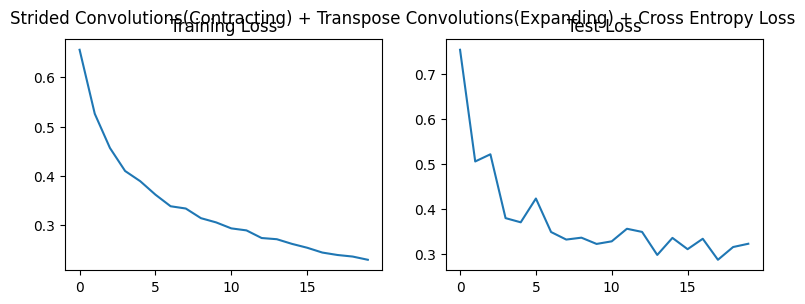

In [22]:
loss.plot_losses(train_losses=train_losses,
                 test_losses=test_losses,
                 title="Strided Convolutions(Contracting) + Transpose Convolutions(Expanding) + Cross Entropy Loss")

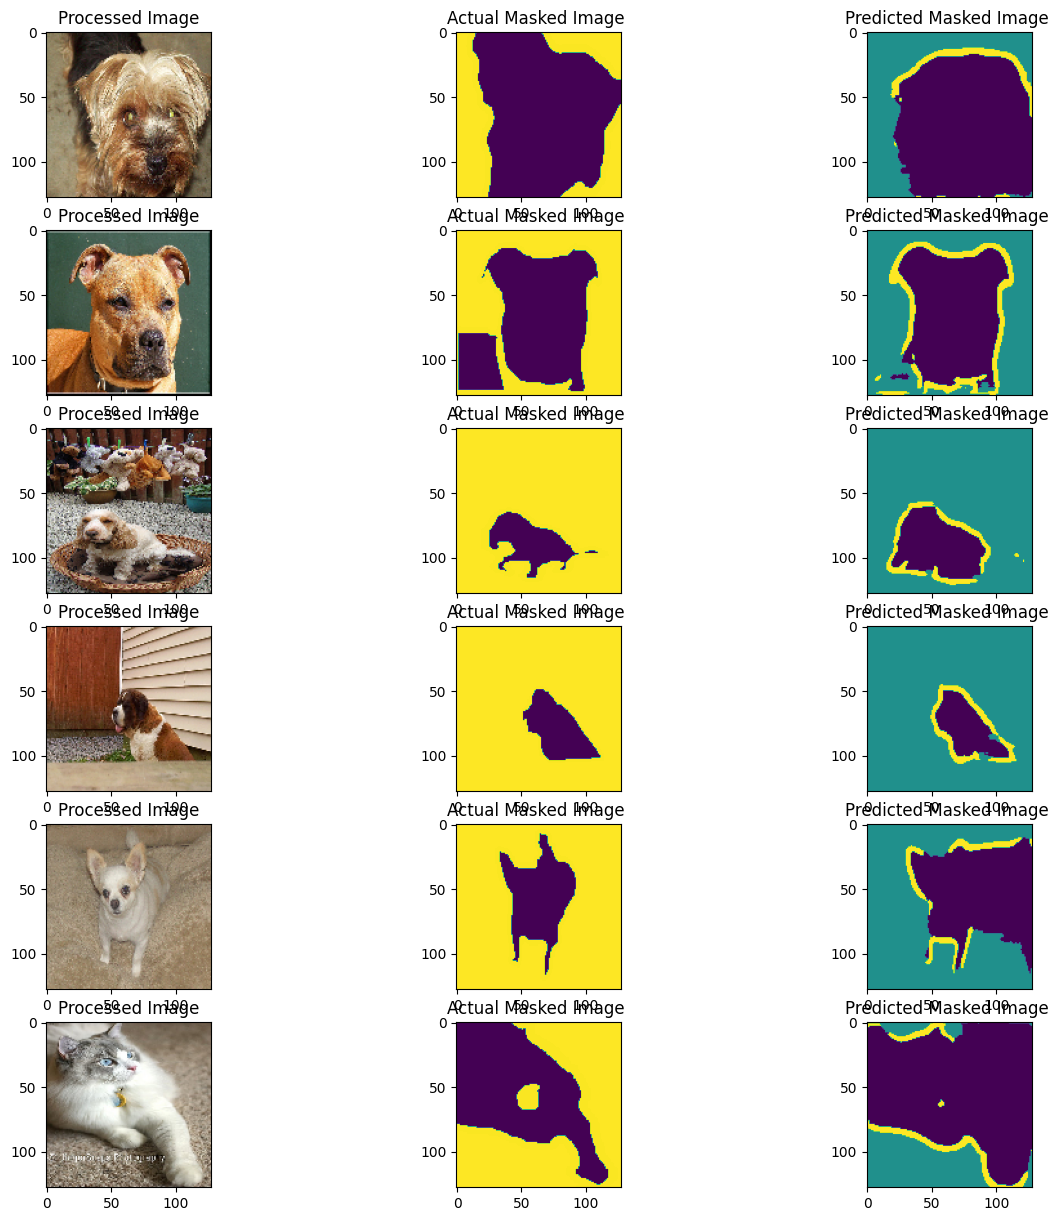

In [23]:
predictions.VisualizeResults(unet_model = unet_3, test_dataloader=test_dataloader)

#### Model Configuration: StrConv + Ups + Dice Loss

In [24]:
unet_4 = Unet(in_channels=3, out_channels=3,StrConv=True,ConvTr=False).to(config.device)
optimizer = torch.optim.Adam(params = unet_4.parameters(),lr=0.001)
print(summary(model= unet_4, input_size=(32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                              [32, 3, 128, 128]    [32, 3, 128, 128]    --                   True
├─ContractingBlock (contract1)           [32, 3, 128, 128]    [32, 32, 64, 64]     --                   True
│    └─Conv2d (conv1)                    [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
│    └─BatchNorm2d (bn1)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu1)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (conv2)                    [32, 32, 128, 128]   [32, 32, 128, 128]   9,248                True
│    └─BatchNorm2d (bn2)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu2)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (str

In [25]:
train_losses,test_losses = train.train_unet(my_unet=unet_4,
                                            loss_fn=loss.dice_loss_fn,
                                            device=config.device,
                                            train_dataloader=train_dataloader,
                                            test_dataloader=test_dataloader,
                                            optimizer=optimizer)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3997 | test_loss: 0.2988 
Epoch: 2 | train_loss: 0.2987 | test_loss: 0.3126 
Epoch: 3 | train_loss: 0.2675 | test_loss: 0.2402 
Epoch: 4 | train_loss: 0.2477 | test_loss: 0.2515 
Epoch: 5 | train_loss: 0.2393 | test_loss: 0.2459 
Epoch: 6 | train_loss: 0.2263 | test_loss: 0.2360 
Epoch: 7 | train_loss: 0.2240 | test_loss: 0.2302 
Epoch: 8 | train_loss: 0.2149 | test_loss: 0.2069 
Epoch: 9 | train_loss: 0.2084 | test_loss: 0.2161 
Epoch: 10 | train_loss: 0.2040 | test_loss: 0.2084 
Epoch: 11 | train_loss: 0.2007 | test_loss: 0.2044 
Epoch: 12 | train_loss: 0.1949 | test_loss: 0.2105 
Epoch: 13 | train_loss: 0.1935 | test_loss: 0.2058 
Epoch: 14 | train_loss: 0.1899 | test_loss: 0.2063 
Epoch: 15 | train_loss: 0.1870 | test_loss: 0.1943 
Epoch: 16 | train_loss: 0.1852 | test_loss: 0.1914 
Epoch: 17 | train_loss: 0.1796 | test_loss: 0.1844 
Epoch: 18 | train_loss: 0.1768 | test_loss: 0.1843 
Epoch: 19 | train_loss: 0.1740 | test_loss: 0.1877 
Epoch: 20 | train_los

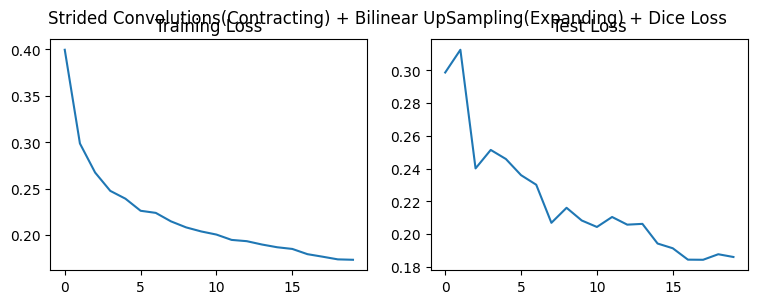

In [26]:
loss.plot_losses(train_losses=train_losses,
                 test_losses=test_losses,
                 title="Strided Convolutions(Contracting) + Bilinear UpSampling(Expanding) + Dice Loss")

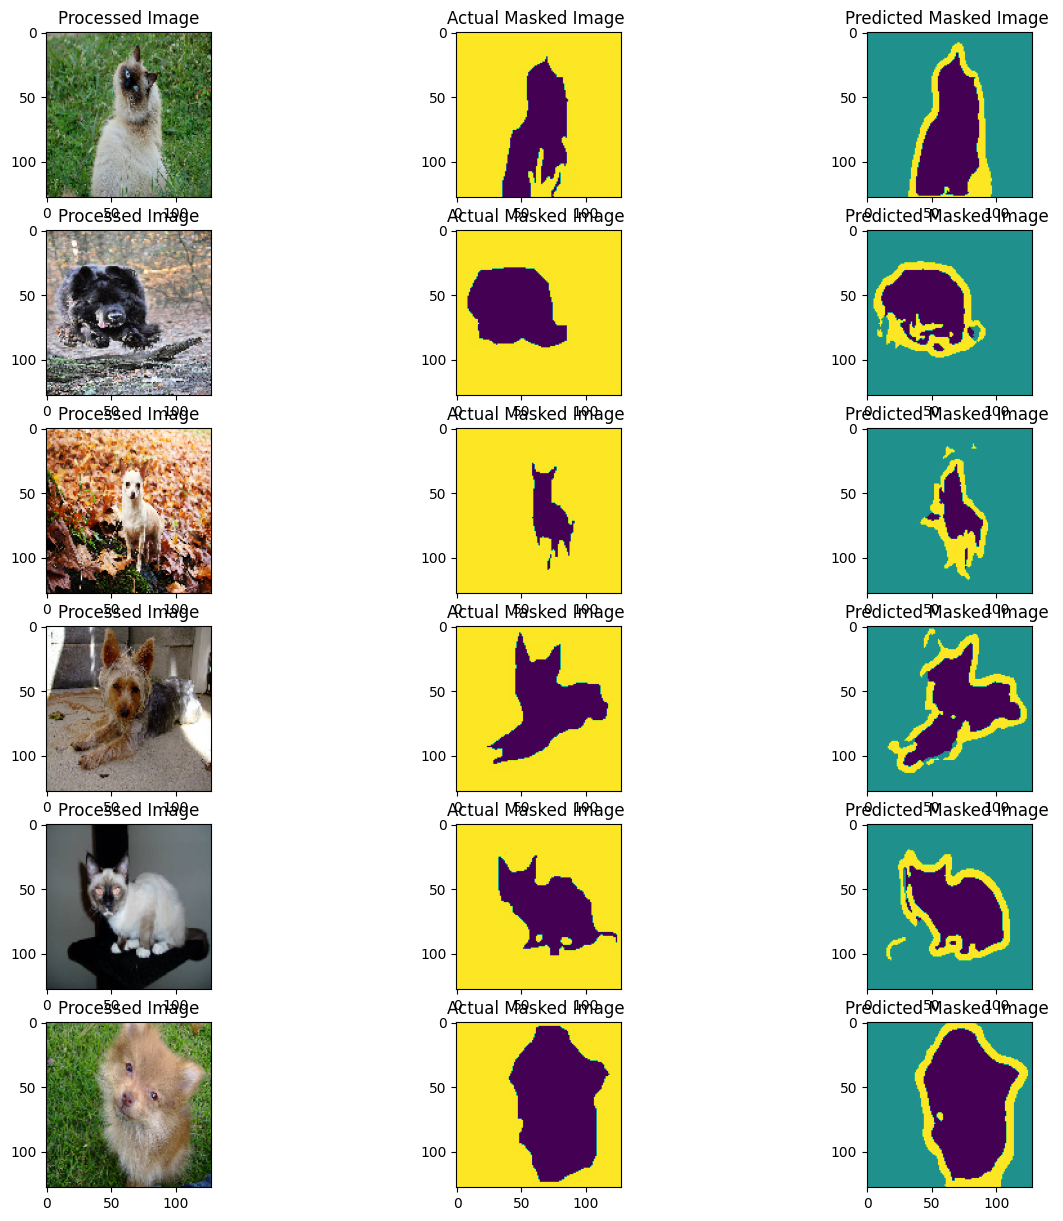

In [27]:
predictions.VisualizeResults(unet_model = unet_4, test_dataloader=test_dataloader)